In [1]:
!pip install -U transformers 
!pip install -U datasets

In [2]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam

from datasets import load_dataset
from transformers import BertModel, BertTokenizer
from transformers import get_linear_schedule_with_warmup

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
ds = load_dataset('snli')

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
train_ds = ds['train']
test_ds = ds['test']

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
train_ds = train_ds.filter(lambda x: x['label']>=0)

Filter:   0%|          | 0/550152 [00:00<?, ? examples/s]

In [7]:
max_seq_len = 128

In [8]:
train_ds = train_ds.select(range(100000))

In [9]:
def tokenizer_mapping(x):
    premise_enc = tokenizer.batch_encode_plus(x['premise'], truncation=True, padding='max_length', max_length=max_seq_len, return_tensors='pt', return_token_type_ids=False)
    hypothesis_enc = tokenizer.batch_encode_plus(x['hypothesis'], truncation=True, padding='max_length', max_length=max_seq_len, return_tensors='pt', return_token_type_ids=False)
    label = nn.functional.one_hot(torch.tensor(x['label']),3)
    out = {
        'premise_input_ids':premise_enc['input_ids'],
        'premise_mask':premise_enc['attention_mask'],
        'hypothesis_input_ids':hypothesis_enc['input_ids'],
        'hypothesis_mask':hypothesis_enc['attention_mask'],
        'label':label
    }
    return out

In [12]:
train_ds_tokenized = train_ds.map(tokenizer_mapping, batched=True, num_proc=4)

Map (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

In [13]:
train_ds_tokenized.set_format(type='torch', columns=['premise_input_ids', 'premise_mask', 'hypothesis_input_ids', 'hypothesis_mask', 'label'])

In [14]:
from torch.utils.data import DataLoader

In [15]:
loader = DataLoader(train_ds_tokenized, batch_size=64, shuffle=True, num_workers=2)

In [16]:
class Siamese_BERT(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model
        for p in bert_model.parameters():
            p.requires_grad=False
        self.classifier = nn.Linear(768*3,3,bias=False)
    def pool(self, x, mask):
        x = x[0]
        mask_expanded = mask.unsqueeze(-1).expand(x.size()).float()
        return torch.sum(x * mask_expanded, 1) / torch.clamp(mask_expanded.sum(1), min=1e-9)
    def similarity(self,x1,x2):
        sim = x1-x2
        return torch.cat([x1,x2,sim],1)
    def forward(self, x1, x1_mask, x2, x2_mask):
        x1_out = self.bert(x1,attention_mask=x1_mask)
        x2_out = self.bert(x2,attention_mask=x2_mask)
        x1_pooled = self.pool(x1_out, x1_mask)
        x2_pooled = self.pool(x2_out, x2_mask)
        out = self.similarity(x1_pooled,x2_pooled)
        out = self.classifier(out)
        return out


In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

model = Siamese_BERT(bert_model)

In [ ]:
#config

lr = 2e-5
EPOCHS = 5

optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1*EPOCHS*len(loader), num_training_steps = 0.9*EPOCHS*len(loader))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
model = model.to(device)

In [20]:
test_ds = test_ds.filter(lambda x: x['label']>=0)
test_ds_tokenzied = test_ds.map(tokenizer_mapping, batched=True)
test_ds_tokenzied.set_format(type='torch', columns=['premise_input_ids', 'premise_mask', 'hypothesis_input_ids', 'hypothesis_mask', 'label'])
test_dataloader = DataLoader(test_ds_tokenzied, batch_size=64, shuffle=False)

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

In [22]:
def train_step(epoch_no):
    model.train()
    running_loss = 0.0
    total_loss = 0.0
    print(f"Epoch {epoch_no}\n"+"-"*25)
    for step, batch in enumerate(loader):
        x1 = batch['premise_input_ids'].to(device)
        x2 = batch['hypothesis_input_ids'].to(device)
        x1_mask = batch['premise_mask'].to(device)
        x2_mask = batch['hypothesis_mask'].to(device)
        y = batch['label'].to(device)
        out = model(x1, x1_mask, x2, x2_mask)
        loss = criterion(out, y.to(torch.float))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        total_loss += loss.item()
        if step % 500 == 499:
            print(f'[{epoch_no}, {step:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0
    return total_loss/len(loader)

In [29]:
def eval_step():
    model.eval()
    total_loss = 0.0
    correct_pred = 0
    with torch.no_grad():
        for batch in test_dataloader:
            x1 = batch['premise_input_ids'].to(device)
            x2 = batch['hypothesis_input_ids'].to(device)
            x1_mask = batch['premise_mask'].to(device)
            x2_mask = batch['hypothesis_mask'].to(device)
            y = batch['label'].to(device)
            preds = model(x1,x1_mask,x2,x2_mask)
            loss = criterion(preds, y.to(torch.float))
            total_loss += loss.item()
            correct_pred += torch.sum(torch.argmax(preds, dim=-1) == torch.argmax(y,dim=-1)).item()
    return total_loss/len(test_dataloader), correct_pred/len(test_ds)*100


In [31]:
eval_metrics = {
    "train_losses" : [],
    "test_losses" : []
}

for epoch in range(EPOCHS):
    train_loss = train_step(epoch)
    print(f'Average train loss = {train_loss:.4f}')
    test_loss, acc = eval_step()
    print(f'Average test loss = {test_loss} accuracy = {acc:.2f}')
    eval_metrics['train_losses'].append(train_loss)
    eval_metrics['test_losses'].append(test_loss)

print(f'------------Training finished for {EPOCHS} epochs--------------')

Epoch 0
-------------------------
[0,   499] loss: 1.098
[0,   999] loss: 1.061
[0,  1499] loss: 1.024
Average train loss = 1.0592
Average test loss = 0.9945427585731853 accuracy = 53.78
Epoch 1
-------------------------
[1,   499] loss: 0.999
[1,   999] loss: 0.986
[1,  1499] loss: 0.973
Average train loss = 0.9851
Average test loss = 0.9502707963640039 accuracy = 56.23
Epoch 2
-------------------------
[2,   499] loss: 0.967
[2,   999] loss: 0.959
[2,  1499] loss: 0.952
Average train loss = 0.9592
Average test loss = 0.9323644204573198 accuracy = 56.81
Epoch 3
-------------------------
[3,   499] loss: 0.950
[3,   999] loss: 0.948
[3,  1499] loss: 0.952
Average train loss = 0.9496
Average test loss = 0.9255002380965592 accuracy = 57.40
Epoch 4
-------------------------
[4,   499] loss: 0.948
[4,   999] loss: 0.946
[4,  1499] loss: 0.945
Average train loss = 0.9463
Average test loss = 0.9250462132614928 accuracy = 57.36
------------Training finished for 5 epochs--------------


In [32]:
import matplotlib.pyplot as plt

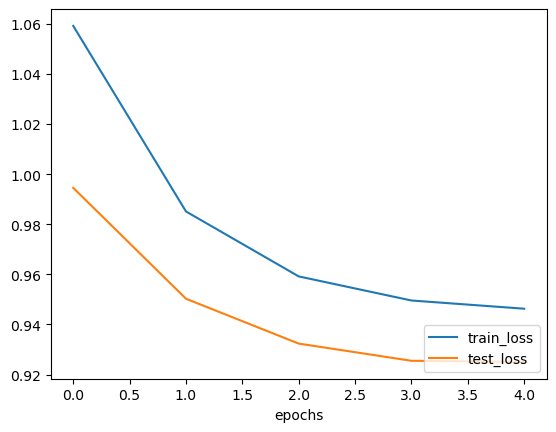

In [34]:
#plot train and test loss 

plt.plot(eval_metrics['train_losses'], label='train_loss')
plt.plot(eval_metrics['test_losses'], label='test_loss')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.show()